# Scientific Computation on Sagemaker

Amazon SageMaker is a fully-managed service that enables developers and data scientists to quickly and easily build, train, and deploy machine learning models at any scale. But besides streamlining the machine learning workflow, SageMaker also provides a powerful, flexible and easy to use compute environment to execute and parallelize a large spectrum of scientific computing tasks. In this notebook we demostrate how to simulate a simple quantum system using Amazon SageMaker's _Bring You Own Algorithm_ (BYOA) functionality.

## Some Background on the Problem (feel free to skip)

The quantum effect we are going to simulate is known under the name of [superradiance](https://en.wikipedia.org/wiki/Superradiance "Wikipedia"). It describes a phenomenon where, under certain conditions, independent light emitters (such as individual atoms) spontaneously build up quantum coherence and act cooperatively as a single entity. Interestingly, this effect is not based on any interaction between the particles but rather arises purely from symmetry properties of the particles' interaction with the light field. The coherence build-up causes the group to emit light as a high intensity pulse. This pulse is N times (!) stronger than the intensity expected from a group of independent particles, where N is the number of particles in the group.  

![Superradiance](superradiance.png)
*Fig. 1: Light emission profiles are distincly different for independent (upper panel) and superradiant (lower panel) particle ensembles. Superradiance causes a spatially directed, short time, and high intensity pulse as opposed to the classical exponentially decaying emission profile.*

Superradiance has been observed or proposed in [many](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.30.309 "Atoms") [different](http://science.sciencemag.org/content/285/5427/571 "Bose-Einstein Condensates") [quantum](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.87.124026 "Black Holes") [systems](https://www.nature.com/articles/nphys494 "Quantum Dot Lattices"). We are going to examine in the following [superradiance from the nuclear spin ensemble of semiconductor Quantum Dots](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.104.143601) . 

## Setup

When operating in BYOA mode, SageMaker utilizes Amazon Elastic Container Service (ECS) to manage and deploy the Docker images that contain our code. Therefore, running this notebook requires additional permission in addition to the standard SageMakerFullAccess. The easiest way to add these permissions is simply to add the managed policy AmazonEC2ContainerRegistryFullAccess to the role that you used to start your notebook instance in the Sagemaker dashboard. There's no need to restart your notebook instance when you do this, the new permissions will be available immediately.

To run this notebook, first, copy this repo onto your SageMaker instance. The repo contains a `container` directory that has all the components you need to package the sample algorithm for Amazon SageMager:

    .
    ├── Dockerfile
    ├── build_and_push.sh
    ├── local_test
    └── superradiance
        ├── train
        └── utils.py

Let's discuss each of these in turn:

* __`Dockerfile`__ describes how to build your Docker container image. More details [here](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/scikit_bring_your_own/scikit_bring_your_own.ipynb).
* __`build_and_push.sh`__ is a script that users the Dockerfile to build your container images and then pushes it to ECR. 
* __`superradiance`__ is the directory which contains the files that will be installed in the container, in our case, it's a simple tensorflow script to perform the stepwise evolution of our system's Master Equation.
* __`local_test`__ is a directory that shows how to test your new container on any computer that can run Docker, including an Amazon SageMaker notebook instance. Using this method, you can quickly iterate using small datasets to eliminate any structural bugs before you use the container with Amazon SageMaker. 

`superradiance/train` is the program that is invoked when the container is run for training. It takes a few parameters and the initial state of the system as input, runs a simulation of the system, and returns the emission profile. For the moment, let's not worry about how this simulation works (we'll come back to that later). 

To build the docker image and push it to ECS we need to run the script `build_and_push.sh`. To this end start a terminal session on your SageMaker notebook instance, navigate to the container directory and run:

```
chmod +x build_and_push.sh
./build_and_push.sh superradiance
```

The script will build a Docker image from the Dockerfile including the program in the superradiance directory and push it to the ECS repo with name 'superradiance' (argument passed to build_and_push.sh). If the repo doesn't exist it will be created for you. 

Now we are ready to execute our simulation on SageMaker.

Let's first import some modules and define some parameters of the simulation

In [18]:
from scipy import sparse
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

import boto3
from sagemaker import get_execution_role
import sagemaker as sage

steps = 500                  # Number of simulated time steps
N = 8                        # Number of nuclear spins
dim = 2**(N+1)               # Dimension of Hilbert space of N nuclear and 1 electronic spin

Let's try out our simulation with 8 nuclear spins and simulating 100 time steps. We will later pass these parameters to our program as 'hyperparameters'. 

Next, we define the initial state of the system. The state of a quantum system is usually represented through the so-called density matrix. We will define a simple initial state of the nuclear (all pointing up) and electron spins (pointing down) as a sparse matrix. Then we upload this state to S3. The simulation will later retrieve this data to initialize the system.

In [19]:
# Define Nuclear and Electron spin states as density matrices
rhoI = sparse.csr_matrix(([1.],([0],[0])),shape =(int(dim/2),int(dim/2))) # All nuclear spins up
rhoS = sparse.csr_matrix(([1.],([1],[1])),shape =(2,2))                   # Electron spin down
sparse_rho =sparse.kron(rhoS, rhoI)                                       # Build the system density matrix

tempfile = '/tmp/tmp.pckl'
pickle.dump(sparse_rho, open(tempfile, "wb"))

# Upload serialized initial state to S3
resource = boto3.resource('s3') 
my_bucket = resource.Bucket('sagemaker-kessle31')                         #subsitute this for your s3 bucket name. 
my_bucket.upload_file(tempfile, Key='superradiance/initial_state/init.pckl')

# Clean-up temporary files
os.remove(tempfile)  

At time=0 our system is initialized to all nuclear spins pointing 'up', and the electron spin pointing 'down'. Now everything is ready to ship our simulation. After specifying the Docker image to be used, we will create a training job that specifies the hardware to be used for the simulation. SageMaker will then spin up the requested instances, pull the specified Docker image from ECS, and execute the job. 

In [20]:
role = get_execution_role()
sess = sage.Session()

# Specify the name of the ECS repo that contains your docker image. 
# By default the image with tag 'latest' in the repo will be utilized.
imagename = 'superradiance'  

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/{}'.format(account, region, imagename)

# Define the training job
superradiance = sage.estimator.Estimator(image,
                       role, 1, 'ml.c4.2xlarge',
                       output_path="s3://sagemaker-kessle31/superradiance/output",
                       sagemaker_session=sess)

# Parameters can be passed to the simulation as a dictionary
superradiance.hyperparam_dict = {'N': N, 'steps': steps}

# Pass the location of the training data (see above) and start the job
superradiance.fit("s3://sagemaker-kessle31/superradiance/initial_state")

INFO:sagemaker:Creating training-job with name: superradiance-2018-01-18-16-48-12-815


.......................................................
Starting the training.
['init.npy', 'index.html', 'init.pckl', 'test.npy']
2018-01-18 16:52:33.767503: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
Training complete.
===== Job Complete =====


The results of the simulation will be placed as a tar.gz file in the S3 location specified by `output_path`. Let's have a look at the results!

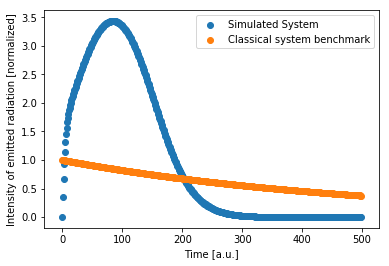

In [24]:
import tarfile

# get the results from S3
results = my_bucket.Object('superradiance/output/{}/output/model.tar.gz'.format(superradiance.latest_training_job.name))
tempfile = '/tmp/model.tar.gz'   
results.download_file('/tmp/model.tar.gz')    

# unzip the results
tar = tarfile.open(tempfile, "r:gz")
tar.extractall(path = '/tmp')

# load the results into the notebook
out = pickle.load(open('/tmp/out.pckl', "rb"))
intensity = out['intensity']
I_ind = out['I_ind']

# clean-up temporary files
os.remove(tempfile) 

# Vizualize the results
plt.scatter(range(steps-1),intensity/I_ind, label = 'Simulated System')
plt.scatter(range(steps-1), np.exp(-I_ind/N * np.arange(steps-1)), label = 'Classical system benchmark')
plt.xlabel('Time [a.u.]')
plt.ylabel('Intensity of emitted radiation [normalized]')
plt.legend()

plt.show()